In [1]:
import warnings
import seaborn as sns
import tensorflow_probability as tfp  # tensorflow probability
import jax  # autograd + XLA
import jax.numpy as jnp  # ai-accelerator agnostic numpy implementations
import pandas as pd  # lets us handle data as dataframes
import matplotlib.pyplot as plt  # sets up plotting under plt
import matplotlib.cm as cm  # allows us easy access to colormaps
import matplotlib as mpl  # this actually imports matplotlib
import scipy as sp  # imports stats functions, amongst other things
import numpy as np  # imports a fast numerical programming library
from operator import index
from jax import random, jit, value_and_grad
from jax.config import config
from scipy.optimize import minimize
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import jit
import optax as ox
key = jr.PRNGKey(123)

warnings.filterwarnings("ignore")

%matplotlib inline


In [2]:
import seaborn as sns

In [3]:
n = 1000
noise = 0.2

x = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

In [4]:
# from sklearn import datasets
# co2_dataset = datasets.fetch_openml(data_id=41187, as_frame=True)
# co2_df = co2_dataset.frame
# co2_df["date"] = pd.to_datetime(co2_df[["year", "month", "day"]])
# co2_df = co2_df[["date", "co2"]].set_index("date")
# co2_df = co2_df.resample("M").mean().dropna(axis="index", how="any")

# co2_df.plot(figsize=(14, 5))
# plt.ylabel("CO$_2$ concentration (ppm)")
# _ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")
# sns.despine()


In [5]:
# X = (co2_df.index.year + co2_df.index.month / 12).to_numpy().reshape(-1, 1)
# from sklearn import preprocessing as sp
# s = 200
# n = 450
# scaler = sp.StandardScaler()
# scaler = scaler.fit(X[s:n])
# x = scaler.transform(X[s:n])
# y = jnp.array(co2_df["co2"][s:n])
# min_max = sp.MinMaxScaler(feature_range=(0, 5))
# min_max = min_max.fit(y.reshape(-1, 1))
# y = min_max.transform(y.reshape(-1, 1))


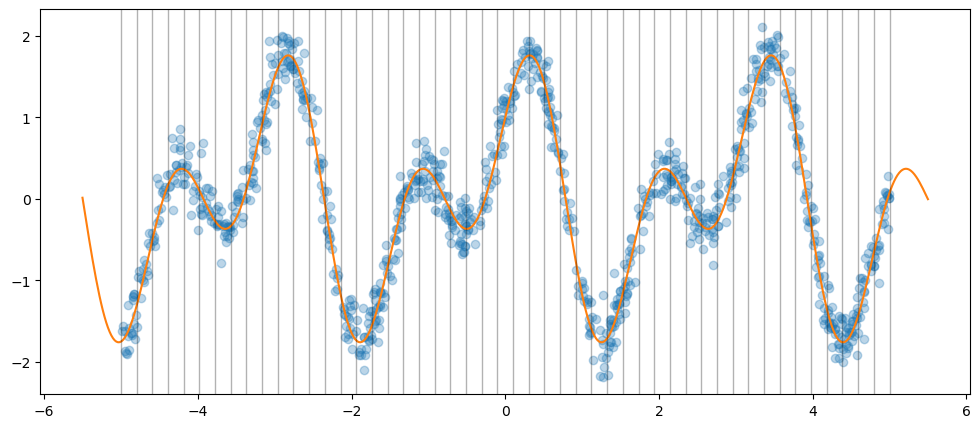

In [6]:
z = jnp.linspace(-5.0, 5.0, 50).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.3, label = "Samples")
ax.plot(xtest, f(xtest), label = "True function")
[ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1) for z_i in z]
plt.show()

In [7]:
from sklearn.gaussian_process.kernels import ExpSineSquared

In [8]:
import numpy as np
import random
from scipy.optimize import minimize
import time
from scipy import spatial as spt
import seaborn as sns
history = []
def Kernel(squared_distances, Lin, Var):
    return (Var**2)*np.exp(-1/(2*Lin**2)*squared_distances)

# def Kernel(squares, length_scale, variance):
#     e.cdist(X, X, metric='sqeuclidean')
#     return variance * jnp.exp(-1/(2*length_scale**2) * squares)

def FindSquareDistances(X, Xm=None):
        if Xm is not None:
            return spt.distance.cdist(X, Xm, metric='sqeuclidean')
        else:
            return spt.distance.cdist(X, X, metric='sqeuclidean')

# def FindSquareDistances(X, Xm= None):
#         if Xm is not None:
#             return 4*(np.sin(3.1415* np.abs(X - Xm)))**2
#         else:

def Train(Lin, Var, Sigma, X, Y, N, M, NoCandidates):
    X = np.vstack(X)    
    Y = np.vstack(Y)    
    start_time = time.time()    # Note 
    Theta = [Lin, Var, Sigma]          # GP hyperparameters

    # Loop over all the candidate sparse points
    for r in range(NoCandidates):

        indices = random.sample(range(N), M)
        X_candidate = X[indices]

        a = (X, Y, X_candidate, N, M)
        LB = -NegLowerBound(Theta, a)

        print(f"Considering inducing point {[ V for V in indices]} now.")
        print(f"LB = {LB}")

        if r == 0:              # For the first set of candidate points
            Xs = X_candidate    # Define optimum sparse inputs found so far
            Ys = Y[indices]    
            LB_best = LB       
        else:
            if LB > LB_best:      
                Xs = X_candidate  # Define optimum sparse inputs found so far
                Ys = Y[indices]   # Define optimum sparse outputs found so far
                LB_best = LB      

    # Update hyperparameters using scipy.minimize
    a = (X, Y, Xs, N, M)  # Arguments needed as input to 'minimize' function
    b1 = (1e-3, 1)        # Bounds on length scale
    b2 = (1e-3, 1)      # Bounds on signal variance
    b3 = (1e-3, 3)      # Bounds on noise variance
    bnds = (b1, b2, b3)
    history = []
    def callback(x_theta):
        fobj = NegLowerBound(x_theta, a)
        history.append(fobj)

    # Search for optimum hyperparameters
    sol = minimize(NegLowerBound, x0=Theta, args=(a, ),
                   method='L-BFGS-B', bounds=bnds, callback = callback)

    [print(f"Iteration {i} : {history[i]}") for i in range(len(history))]
    Theta = sol.x

    Lin, Var, Sigma = Theta                         # Extract hyperparameters
    K = Kernel(FindSquareDistances(Xs), Lin, Var)   # Gram matrix
    C = K + Sigma**2 * np.eye(M)            
    invC = np.linalg.inv(C)                  # Find inverse of C (as in paper!!)
    elapsed_time = time.time() - start_time  # Time taken for training

    

    return Lin, Var, Sigma, K, C, invC, Xs, Ys, LB_best, elapsed_time


def NegLowerBound(Theta, a):
    X, Y, Xs, N, M = a  # Extract arguments
    Lin, Var, Sigma = Theta    # Extract hyperparameters
    K_MM = Kernel(FindSquareDistances(Xs), Lin, Var)     # Find K_MM
    InvK_MM = np.linalg.inv(K_MM)                 # Find inverse of K_MM
    K_NM = Kernel(FindSquareDistances(X, Xs), Lin, Var)  # Find K_NM
    K_MN = np.transpose(K_NM)                     # Find K_MN

    # We define A = K_NM^T * invK_MM * K_MN
    A = np.dot(K_NM, np.dot(InvK_MM, K_MN))
    # print("CAME HERE!")
    
    B = np.zeros(N)
    for i in range(N):
        B[i] = 1 - A[i, i]

    # Calculate the (negative) lower bound
    C = A+np.eye(N)*Sigma**2
    Sign, LogDetC = np.linalg.slogdet(C)
    LogDetC = Sign*LogDetC
    NLB = -(-0.5*LogDetC - 0.5*np.dot(Y.T, np.dot(np.linalg.inv(C), Y))
            - 1/(2*Sigma**2)*np.sum(B))
    return NLB.ravel()



def Predict(X, xStar, Lin, Var, Sigma, Y, K, C, InvC, N):
    ''' Standard GP prediction
    '''
    if np.size(X[0]) == 1:
        squared_distances = (X-xStar)**2
    else:
        squared_distances = np.sum((X-xStar)**2, 1)
    k = Kernel(squared_distances, Lin, Var)
    c = 1 + Sigma**2   # Always true for this particular kernel
    yStarMean = np.dot(k.T, np.dot(InvC, Y))
    yStarStd = np.sqrt(c - np.dot(k.T, np.dot(InvC, k)))

    if c - np.dot(k.T, np.dot(InvC, k)) < 0:
        print("HELLELUHAH :", c - np.dot(k.T, np.dot(InvC, k)))
        print("AAAAA WE ENTERED THIS PLACE")
    return yStarMean, yStarStd

In [9]:
Theta = 0.413, 1.85

Ran for 4 minutes -- nothing showing for 10,000 data points.

In [10]:
L = 2, 3
a, b = L
b

3

Considering inducing point [287, 964, 847, 782, 78, 775, 480, 6, 950, 753, 69, 728, 540, 657, 580, 701, 823, 345, 603, 906, 134, 381, 914, 257, 688, 568, 863, 784, 417, 255, 445, 556, 307, 375, 131, 812, 714, 475, 34, 160, 197, 986, 84, 258, 352, 545, 583, 494, 900, 721, 904, 704, 401, 303, 927, 631, 187, 424, 439, 920, 563, 214, 337, 598, 764, 79, 280, 267, 32, 46, 232, 349, 107, 646, 788, 607, 890, 897, 253, 98, 448, 402, 541, 575, 999, 810, 937, 215, 240, 953, 512, 7, 109, 146, 126, 589, 926, 846, 403, 190, 567, 272, 955, 407, 571, 916, 442, 59, 477, 676, 464, 582, 482, 463, 870, 736, 959, 804, 5, 120, 949, 532, 172, 422, 700, 380, 133, 198, 768, 282, 996, 386, 772, 724, 723, 754, 976, 854, 533, 481, 645, 75, 40, 86, 778, 171, 859, 638, 985, 222, 200, 191, 12, 10, 170, 626, 813, 965, 431, 690, 41, 915, 229, 45, 390, 845, 174, 681, 706, 948, 601, 358, 805, 912, 110, 718, 624, 966, 827, 147, 292, 802, 689, 180, 683, 88, 850, 883, 17, 496, 614, 218, 317, 449, 332, 500, 793, 632, 432, 5

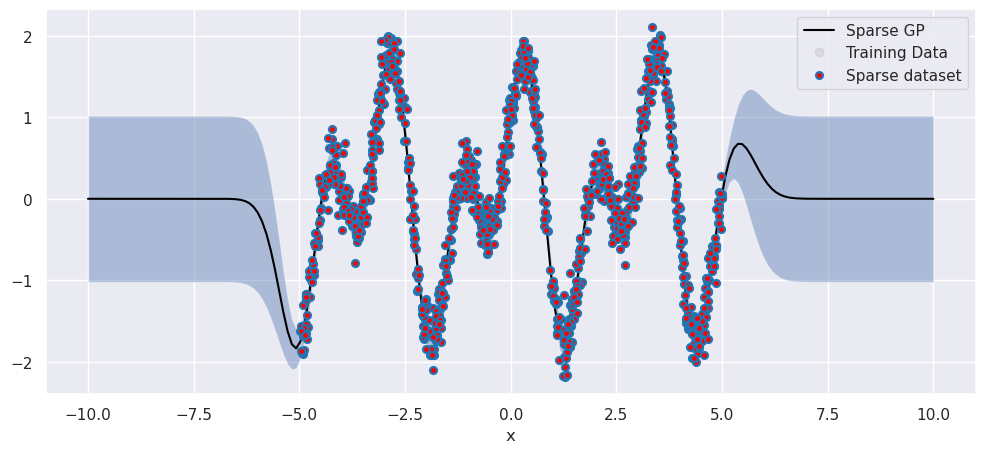

[]

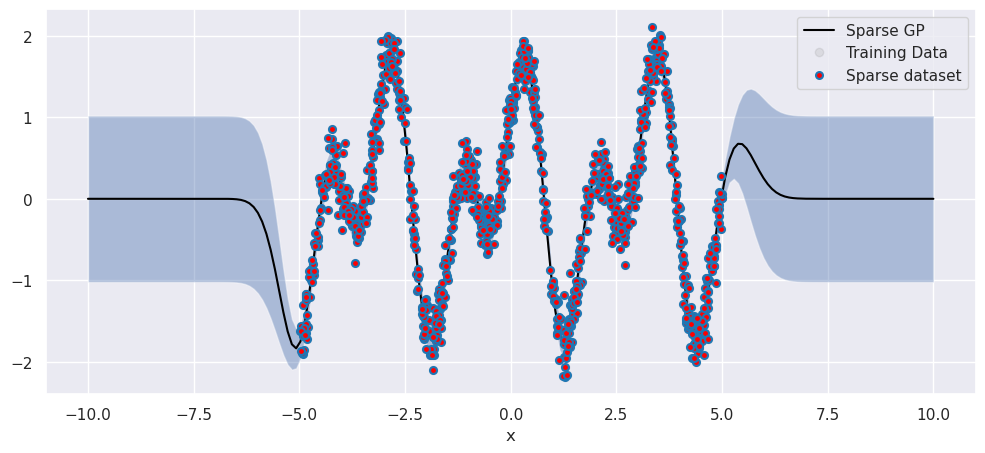

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
"""
BASED ON CODE FROM
University of Liverpool
GITHUB REPO IN PRESENTATION!
"""
N = 1000
X = x
Y = y
# Initial hyperparameters
L0 = 0.5      # Lengthscale
V0 = 2.0        # Signal Variance
Sigma0 = 0.2    # Observation Variance

# Train sparse GP
M = 1000              # No. sparse points
NoCandidates = 1      # No. of candidate sets of sparse points analysed
(Lin, Var, Sigma, K, C, InvC, Xs, Ys, LB_best, elapsed_time) = Train(L0, V0, Sigma0,
                                                                  X, Y, N, M,
                                                                  NoCandidates)

print('Maximum lower bound:', LB_best)
print('Hyperparameters:', Lin, Var, Sigma)
print('Elapsed time:', elapsed_time)

# Make some predictions
X_Star = np.linspace(-10, 10, 200)  # Make predictions
N_Star = len(X_Star)              # No. points where we make predictions
Y_StarMean = np.zeros(N_Star)     # Initialise GP mean predictions
Y_StarStd = np.zeros(N_Star)      # Initialise GP std predictions
for n in range(N_Star):
    xStar = X_Star[n]
    Y_StarMean[n], Y_StarStd[n] = Predict(Xs, xStar, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)


# Make some predictions
X_Test = X  # Make predictions
N_Test = len(X_Test)              # No. points where we make predictions
Y_TestMean = np.zeros(N_Test)     # Initialise GP mean predictions
Y_TestStd = np.zeros(N_Test)      # Initialise GP std predictions
for n in range(N_Test):
    xTest = X_Test[n]
    Y_TestMean[n], Y_TestStd[n] = Predict(Xs, xTest, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)



# Plot results
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_Star, Y_StarMean, 'black', label='Sparse GP')
ax.fill_between(X_Star, Y_StarMean - Y_StarStd,
                 Y_StarMean + Y_StarStd, alpha = 0.4)
# plt.plot(X_Star, Y_StarMean - 3 * Y_StarStd, 'black')
ax.plot(X, Y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(Xs, Ys, 'o', markerfacecolor='red',
        markeredgewidth=1.5, markersize=5, label='Sparse dataset', color="tab:blue")
plt.xlabel('x')
plt.legend()
plt.show()

Lin = 0.5
Var = 1
# Make some predictions
X_Star = np.linspace(-10, 10, 200)  # Make predictions
N_Star = len(X_Star)              # No. points where we make predictions
Y_StarMean = np.zeros(N_Star)     # Initialise GP mean predictions
Y_StarStd = np.zeros(N_Star)      # Initialise GP std predictions
for n in range(N_Star):
    xStar = X_Star[n]
    Y_StarMean[n], Y_StarStd[n] = Predict(Xs, xStar, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)

# Plot results
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_Star, Y_StarMean, 'black', label='Sparse GP')
ax.fill_between(X_Star, Y_StarMean - Y_StarStd,
                 Y_StarMean + Y_StarStd, alpha = 0.4)
# plt.plot(X_Star, Y_StarMean - 3 * Y_StarStd, 'black')
ax.plot(X, Y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(Xs, Ys, 'o', markerfacecolor='red',
        markeredgewidth=1.5, markersize=5, label='Sparse dataset', color="tab:blue")
plt.xlabel('x')
plt.legend()
plt.plot()


Considering inducing point [553, 867, 679, 86, 746, 425, 922, 756, 477, 414, 302, 699, 498, 911, 21, 105, 126, 29, 814, 944, 386, 691, 861, 744, 284, 209, 665, 438, 780, 327, 128, 44, 0, 364, 866, 976, 618, 612, 584, 823, 633, 921, 412, 557, 9, 388, 82, 576, 938, 577, 210, 207, 667, 125, 873, 431, 960, 170, 863, 81, 97, 448, 111, 118, 988, 257, 455, 202, 502, 288, 59, 671, 493, 893, 423, 751, 820, 535, 464, 724, 225, 773, 519, 203, 647, 825, 881, 159, 868, 697, 673, 401, 940, 69, 778, 850, 465, 254, 95, 306, 312, 818, 451, 76, 42, 539, 140, 869, 628, 184, 510, 249, 241, 601, 793, 439, 507, 279, 700, 488, 347, 717, 560, 781, 517, 112, 291, 40, 591, 723, 604, 219, 545, 589, 232, 832, 13, 47, 659, 626, 839, 917, 740, 953, 23, 791, 817, 57, 692, 444, 405, 994, 342, 931, 963, 176, 421, 838, 611, 443, 910, 981, 830, 666, 774, 34, 737, 169, 78, 129, 88, 770, 851, 775, 600, 255, 323, 630, 766, 828, 117, 524, 844, 172, 800, 607, 375, 928, 876, 993, 880, 84, 587, 381, 870, 923, 966, 906, 460, 51

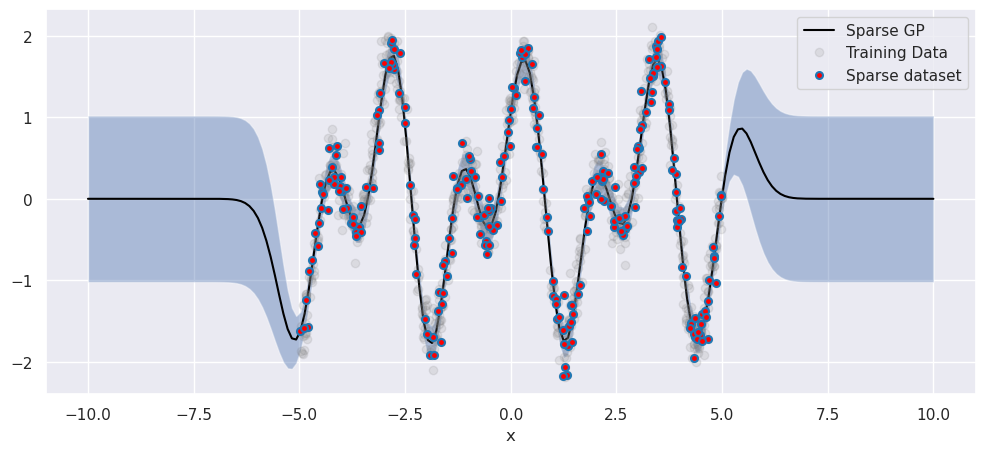

[]

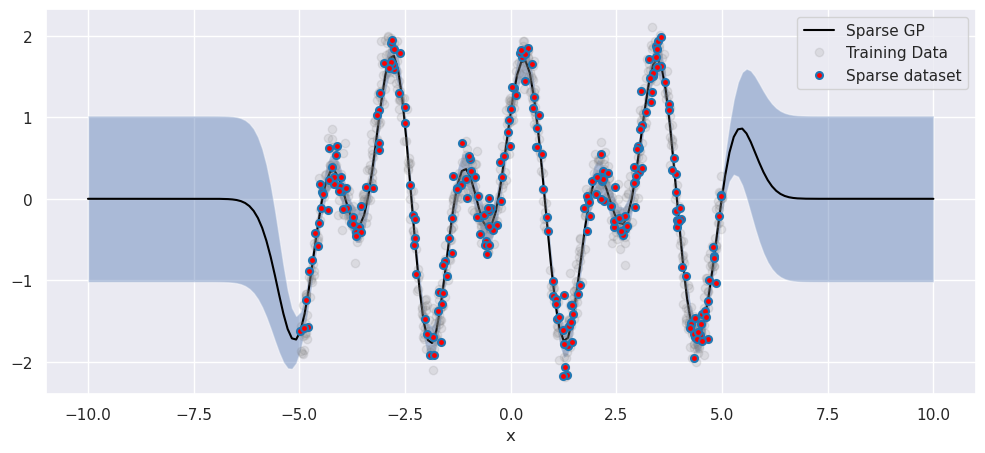

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
"""
BASED ON CODE FROM
University of Liverpool
GITHUB REPO IN PRESENTATION!
"""
N = 1000
X = x
Y = y
# Initial hyperparameters
L0 = 0.5      # Lengthscale
V0 = 2.0        # Signal Variance
Sigma0 = 0.2    # Observation Variance

# Train sparse GP
M = 250               # No. sparse points
NoCandidates = 1      # No. of candidate sets of sparse points analysed
(Lin, Var, Sigma, K, C, InvC, Xs, Ys, LB_best, elapsed_time) = Train(L0, V0, Sigma0,
                                                                  X, Y, N, M,
                                                                  NoCandidates)

print('Maximum lower bound:', LB_best)
print('Hyperparameters:', Lin, Var, Sigma)
print('Elapsed time:', elapsed_time)

# Make some predictions
X_Star = np.linspace(-10, 10, 200)  # Make predictions
N_Star = len(X_Star)              # No. points where we make predictions
Y_StarMean = np.zeros(N_Star)     # Initialise GP mean predictions
Y_StarStd = np.zeros(N_Star)      # Initialise GP std predictions
for n in range(N_Star):
    xStar = X_Star[n]
    Y_StarMean[n], Y_StarStd[n] = Predict(Xs, xStar, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)


# Make some predictions
X_Test = X  # Make predictions
N_Test = len(X_Test)              # No. points where we make predictions
Y_TestMean = np.zeros(N_Test)     # Initialise GP mean predictions
Y_TestStd = np.zeros(N_Test)      # Initialise GP std predictions
for n in range(N_Test):
    xTest = X_Test[n]
    Y_TestMean[n], Y_TestStd[n] = Predict(Xs, xTest, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)



# Plot results
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_Star, Y_StarMean, 'black', label='Sparse GP')
ax.fill_between(X_Star, Y_StarMean - Y_StarStd,
                 Y_StarMean + Y_StarStd, alpha = 0.4)
# plt.plot(X_Star, Y_StarMean - 3 * Y_StarStd, 'black')
ax.plot(X, Y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(Xs, Ys, 'o', markerfacecolor='red',
        markeredgewidth=1.5, markersize=5, label='Sparse dataset', color="tab:blue")
plt.xlabel('x')
plt.legend()
plt.show()

Lin = 0.5
Var = 1
# Make some predictions
X_Star = np.linspace(-10, 10, 200)  # Make predictions
N_Star = len(X_Star)              # No. points where we make predictions
Y_StarMean = np.zeros(N_Star)     # Initialise GP mean predictions
Y_StarStd = np.zeros(N_Star)      # Initialise GP std predictions
for n in range(N_Star):
    xStar = X_Star[n]
    Y_StarMean[n], Y_StarStd[n] = Predict(Xs, xStar, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)

# Plot results
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_Star, Y_StarMean, 'black', label='Sparse GP')
ax.fill_between(X_Star, Y_StarMean - Y_StarStd,
                 Y_StarMean + Y_StarStd, alpha = 0.4)
# plt.plot(X_Star, Y_StarMean - 3 * Y_StarStd, 'black')
ax.plot(X, Y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(Xs, Ys, 'o', markerfacecolor='red',
        markeredgewidth=1.5, markersize=5, label='Sparse dataset', color="tab:blue")
plt.xlabel('x')
plt.legend()
plt.plot()


In [13]:
Y_TestMean_ = np.array(Y_TestMean).reshape(-1,1)

In [14]:
# Mean Squared Error!
error = np.sum((Y_TestMean_ - Y)**2)/np.size(Y)

In [16]:
error

DeviceArray(0.04003092, dtype=float32)

In [15]:
error_method1 = error

Considering inducing point [960, 569, 814, 645, 658, 130, 157, 508, 623, 568, 806, 468, 900, 531, 991, 487, 893, 486, 575, 849, 67, 74, 614, 798, 241] now.
LB = [3758.81729876]
Considering inducing point [69, 153, 193, 472, 708, 566, 769, 812, 143, 622, 414, 402, 659, 454, 368, 725, 735, 510, 739, 39, 144, 962, 564, 544, 462] now.
LB = [4554.40829163]
Considering inducing point [981, 939, 616, 953, 189, 550, 643, 905, 774, 638, 457, 658, 898, 676, 661, 763, 5, 252, 598, 25, 851, 952, 82, 895, 618] now.
LB = [3633.85597772]
Considering inducing point [355, 370, 777, 421, 838, 685, 196, 157, 828, 926, 737, 491, 927, 109, 701, 32, 112, 640, 127, 463, 469, 882, 92, 467, 541] now.
LB = [5283.20880091]
Considering inducing point [167, 447, 275, 434, 675, 77, 407, 201, 376, 211, 466, 748, 968, 692, 399, 265, 489, 967, 811, 883, 259, 185, 602, 493, 236] now.
LB = [4645.13474216]
Considering inducing point [400, 539, 598, 439, 249, 235, 819, 753, 698, 894, 87, 754, 334, 932, 953, 5, 546, 89, 65

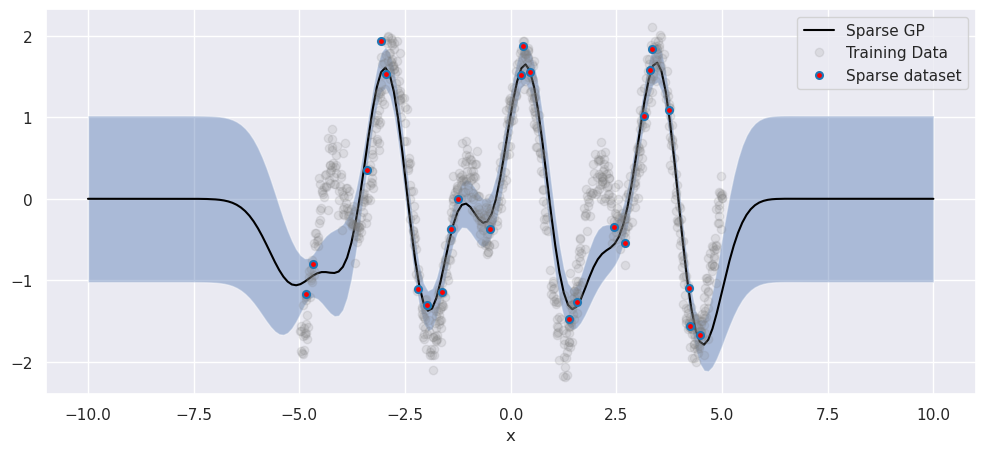

HELLELUHAH : [[-0.01448912]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.01978247]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.01507026]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.01135314]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.02254307]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.01666547]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.01200687]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.01156988]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.00603392]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.00988393]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.03382635]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.03909142]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.02642639]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.00762773]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.00061021]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.00429048]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.00818647]]
AAAAA WE ENTERED THIS PLACE
HELLELUHAH : [[-0.01145432]]
AA

[]

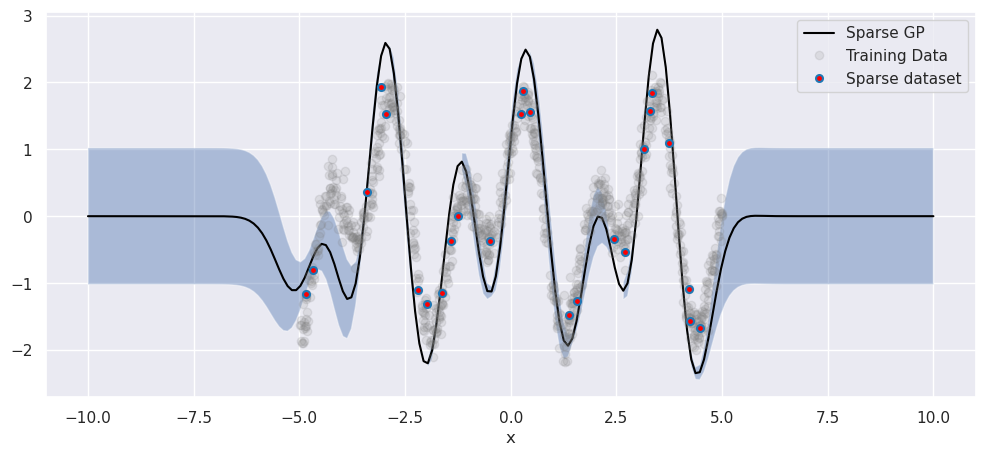

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Make some 1D training data
N = 1000        # 500 training points
X = np.linspace(0, 10, N)       # Inputs evenly spaced between 0 and 10
F = np.sin(X) + np.cos(X) + X              # True function (f = sin(x))
Y = F + 0.1*np.random.randn(N)  # Observations

X = x
Y = y
# Initial hyperparameters
L0 = 0.2      # Lengthscale
V0 = 2.0        # Signal Variance
Sigma0 = 0.4    # Observation Variance

# Train sparse GP
M = 25               # No. sparse points
NoCandidates = 10      # No. of candidate sets of sparse points analysed
(Lin, Var, Sigma, K, C, InvC, Xs, Ys, LB_best, elapsed_time) = Train(L0, V0, Sigma0,
                                                                  X, Y, N, M,
                                                                  NoCandidates)

# Print results
print('Maximum lower bound:', LB_best)
print('Hyperparameters:', Lin, Var, Sigma)
print('Elapsed time:', elapsed_time)

# Make some predictions
X_Star = np.linspace(-10, 10, 200)  # Make predictions
N_Star = len(X_Star)              # No. points where we make predictions
Y_StarMean = np.zeros(N_Star)     # Initialise GP mean predictions
Y_StarStd = np.zeros(N_Star)      # Initialise GP std predictions
for n in range(N_Star):
    xStar = X_Star[n]
    Y_StarMean[n], Y_StarStd[n] = Predict(Xs, xStar, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)

# Plot results
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_Star, Y_StarMean, 'black', label='Sparse GP')
ax.fill_between(X_Star, Y_StarMean - Y_StarStd,
                 Y_StarMean + Y_StarStd, alpha = 0.4)
# plt.plot(X_Star, Y_StarMean - 3 * Y_StarStd, 'black')
ax.plot(X, Y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(Xs, Ys, 'o', markerfacecolor='red',
        markeredgewidth=1.5, markersize=5, label='Sparse dataset', color="tab:blue")
plt.xlabel('x')
plt.legend()
plt.show()

Lin = 0.5
Var = 1
# Make some predictions
X_Star = np.linspace(-10, 10, 200)  # Make predictions
N_Star = len(X_Star)              # No. points where we make predictions
Y_StarMean = np.zeros(N_Star)     # Initialise GP mean predictions
Y_StarStd = np.zeros(N_Star)      # Initialise GP std predictions
for n in range(N_Star):
    xStar = X_Star[n]
    Y_StarMean[n], Y_StarStd[n] = Predict(Xs, xStar, Lin, Var, Sigma,
                                              Ys, K, C, InvC, M)

X_Test = X  # Make predictions
N_Test = len(X_Test)              # No. points where we make predictions
Y_TestMean = np.zeros(N_Test)     # Initialise GP mean predictions
Y_TestStd = np.zeros(N_Test)      # Initialise GP std predictions
for n in range(N_Test):
    xTest = X_Test[n]
    Y_TestMean[n], Y_TestStd[n] = Predict(Xs, xTest, Lin, Var, Sigma,
                                          Ys, K, C, InvC, M)

# Plot results
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_Star, Y_StarMean, 'black', label='Sparse GP')
ax.fill_between(X_Star, Y_StarMean - Y_StarStd,
                 Y_StarMean + Y_StarStd, alpha = 0.4)
# plt.plot(X_Star, Y_StarMean - 3 * Y_StarStd, 'black')
ax.plot(X, Y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(Xs, Ys, 'o', markerfacecolor='red',
        markeredgewidth=1.5, markersize=5, label='Sparse dataset', color="tab:blue")
plt.xlabel('x')
plt.legend()
plt.plot()


In [25]:
Y_TestMean_ = np.array(Y_TestMean).reshape(-1,1)

In [26]:
error_method2 = np.sum((Y_TestMean_[200:800] - Y[200:800])**2)

In [27]:
error_method2/600

DeviceArray(0.32013503, dtype=float32)

In [18]:
Theta = [0.7043199215617603, 1.0, 0.487]
a = (X, Y, Xs, N, M)
print("Initial Lower Bound: ", NegLowerBound(Theta, a))

Initial Lower Bound:  [-494.51543307]


# Write down metric here!


# IGNORE -- SGD IMPLEMENTATION NOT WORKING


In [19]:
import numpy as np
from scipy.optimize import OptimizeResult


def sgd(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.001,
    mass=0.9,
    startiter=0,
    maxiter=1000,
    callback=None,
    **kwargs
):
    x = x0
    velocity = np.zeros_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        velocity = mass * velocity - (1.0 - mass) * g
        x = x + learning_rate * velocity

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)


def rmsprop(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.1,
    gamma=0.9,
    eps=1e-8,
    startiter=0,
    maxiter=1000,
    callback=None,
    **kwargs
):
    """``scipy.optimize.minimize`` compatible implementation of root mean
    squared prop: See Adagrad paper for details.
    Adapted from ``autograd/misc/optimizers.py``.
    """
    x = x0
    avg_sq_grad = np.ones_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        avg_sq_grad = avg_sq_grad * gamma + g**2 * (1 - gamma)
        x = x - learning_rate * g / (np.sqrt(avg_sq_grad) + eps)

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)


def adam(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.001,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    startiter=0,
    maxiter=1000,
    callback=None,
    **kwargs
):
    """``scipy.optimize.minimize`` compatible implementation of ADAM -
    [http://arxiv.org/pdf/1412.6980.pdf].
    Adapted from ``autograd/misc/optimizers.py``.
    """
    x = x0
    m = np.zeros_like(x)
    v = np.zeros_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        m = (1 - beta1) * g + beta1 * m  # first  moment estimate.
        v = (1 - beta2) * (g**2) + beta2 * v  # second moment estimate.
        mhat = m / (1 - beta1**(i + 1))  # bias correction.
        vhat = v / (1 - beta2**(i + 1))
        x = x - learning_rate * mhat / (np.sqrt(vhat) + eps)

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)

# CONTINUE

In [20]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import scipy.linalg


class GP:

    def __init__(self, theta, kernel):

        self.theta = theta
        self.kernel_type = kernel

    def prior_kernel(self, x):
        if self.kernel_type == "Gaussian":
            return (self.theta[0]**2)*np.exp(-0.5*(x/self.theta[1])**2)
        # if self.kernel_type == "Matern":
            # PROBABLY NOT WORKING
            # NOT SURE
            # FIXME Matern Kernel formula
        #     return (self.theta[0]**2)*np.exp(-x/self.theta[1])



class VarGPRegression:

    def __init__(self, X_train, Y_train, kernel):
        self.X_train, self.Y_train = X_train.copy(), Y_train.copy()
        self.kernel_type = kernel
        self.sample_size = X_train.shape[0]
        self.selection = []
        self.indices = [*range(self.sample_size)]
        self.all_checked_set = set()

    def reset_prior(self, theta, sigma):
        """
        Used in M_Step
        """
        self.theta = theta
        self.sigma = sigma
        self.gp = GP(theta, self.kernel_type)
        self.Knn = self.K_matrix(self.X_train, self.X_train)

        self.X_induced = None
        self.index_induced = None
        self.Km = None
        self.Km_cholesky = None
        self.Kmn = None
        self.A = None
        self.mu = None

    def update_induced(self, indexes):
        self.index_induced = indexes
        self.X_induced = self.X_train[self.index_induced, :].copy()

        self.Km = self.K_matrix(
            self.X_induced, self.X_induced) + 10**(-8)*np.identity(self.X_induced.shape[0])
        self.Km_cholesky = np.linalg.cholesky(self.Km)
        self.Kmn = self.K_matrix(self.X_induced, self.X_train)

    def update_var_dist(self):
        Sigma_mat = self.Km + (1/self.sigma**2)*np.dot(self.Kmn, self.Kmn.T)
        L = np.linalg.cholesky(Sigma_mat)
        self.mu = (1/self.sigma**2)*np.dot(self.Km,
                                           scipy.linalg.cho_solve((L, True), np.dot(self.Kmn, self.Y_train)))
        self.A = np.dot(self.Km, scipy.linalg.cho_solve((L, True), self.Km))

    def K_matrix(self, X, Y):
        return self.gp.prior_kernel(cdist(X, Y))

    def covariance_cholesky(self):
        Qnn = np.dot(self.Kmn.T,
                     scipy.linalg.cho_solve((self.Km_cholesky, True), self.Kmn))
        return np.linalg.cholesky(Qnn + (self.sigma**2)*np.identity(self.sample_size))

    def trace_term(self):
        X = np.delete(self.X_train, self.index_induced, axis=0)
        Kpp = self.K_matrix(X, X)  # p = (n - m)
        Kpm = self.K_matrix(X, self.X_induced)
        return np.trace(Kpp - np.dot(Kpm,
                        scipy.linalg.cho_solve((self.Km_cholesky, True), Kpm.T)))

    def variationnal_bound(self):
        """ Computes the variational lower bound (FV in Titsias) that will be used
            in the greedy selection algorithm (select induced points and optimize
            hyperparameters)
        """

        n = self.sample_size
        L = self.covariance_cholesky()
        temp = scipy.linalg.cho_solve((L, True), self.Y_train)
        return -0.5*(np.vdot(self.Y_train, temp) + 2*np.sum(np.log(np.diag(L)))
                     + n*np.log(2*np.pi)
                     ) - (1/2*self.sigma**2)*self.trace_term()

    def posterior_mean(self, X):
        """ Computes the posterior mean of the Gaussian process for
            new observations X.
        """

        Kxm = self.K_matrix(X, self.X_induced)
        return np.dot(Kxm,
                      scipy.linalg.cho_solve((self.Km_cholesky, True), self.mu))

    def posterior_cov(self, X):
        """ Computes the posterior covariance matrix of the Gaussian process
            for new observations X.
        """

        Kxx = self.K_matrix(X, X)
        Kxm = self.K_matrix(X, self.X_induced)
        temp = scipy.linalg.cho_solve((self.Km_cholesky, True), Kxm.T)
        tempbis = scipy.linalg.cho_solve((self.Km_cholesky, True), self.A)
        return Kxx - np.dot(Kxm, temp) + np.dot(Kxm, np.dot(tempbis, temp)) + self.sigma**2


class Greedy(VarGPRegression):

    """ Given a variational GP regression model, defines the optimization
        strategy for its hyperparameters and induced points (see Titsias section 3.1).
        
        This strategy can be viewed as an EM algorithm:
            - E step: select a new induced point (among the the training points
              that are not part of the inducing set)
            - M step: optimize the hyperparameters thanks to the variational lower bound                     
    """

    def E_step(self, J):
        """ 
        Given a subset of indexes J (which defines a subset of training points)
            chooses the one which gives the highest variational lower bound.
            
            Updates the regression model adding this point to the final selection 
            of induced points (self.selection) and removing it from the list of 
            training points that we can choose a new induced point from (self.indices)
        """

        result = J[0]
        self.update_induced(self.selection + [J[0]])
        temp = self.variationnal_bound()
        for j in J[1:]:
            self.update_induced(self.selection + [j])
            if temp < self.variationnal_bound():
                result = j

        print(f"Checking across {[F for F in J]}")
        self.all_checked_set.update([F for F in J])
        print(f"{result} added to list of indices.")
        self.selection.append(result)
        self.indices.remove(result)

    def M_step(self, theta0, sigma0):
        """ 
        Optimizes the hyperparameters of the model using a scipy method
        (Quasi - Newton algorithm).
        
        The objective function reset the model for new values of the hyperparameters 
        and then computes -variational lower bound.
        
        theta0 and sigma0 are given in order to initialize the minimize method.
        """

        def objective(x):
            self.reset_prior(x[:-1], x[-1])
            self.update_induced(self.selection)
            return -self.variationnal_bound()
        init = np.hstack((theta0, sigma0))
        result = minimize(objective, init, method='BFGS',
                          options={'gtol': 1e-5, 'disp': True})
        print("theta* = ", result.x[:-1], "sigma* = ", result.x[-1])
        return result.x[:-1], result.x[-1], - result.fun

    def Greedy_selection(self, nbr_induced_points, theta0, sigma0, size):
        """ 
        EM algorithm (see Titsias section 3.1) with "nbr_induced_points" steps
            
            At each step randomly select a subset of the training points that are 
            not part of the inducing set of size = size.
            
            Returns the value of the variational lower bound FV at each step.
        """

        FV = []
        self.reset_prior(theta0, sigma0)
        for m in range(nbr_induced_points):
            print(m, "th step running")
            J = np.random.choice(self.indices, size=size)
            self.E_step(J)
            theta, sigma, f = self.M_step(theta0, sigma0)
            FV.append(f)
        return FV, self.all_checked_set


def predict(Greedy, X_test, theta0, sigma0, m, size):
    """ 
    Main function:        
        Optimizes the hyperparameters of our regression model and select m 
        induced points via a greedy strategy. 
        Then, given a set of new observations X_test, computes the posterior 
        mean and the posterior standard deviation (with the optimal hyperparameters).
        
        m: number of induced points
        size: size of the random subset of training points in which a new induced point
              is chosen at each step
        theta0 , sigma0: initial hyperparameters for the minimize method at each step
    """

    ML, all_checked_set = Greedy.Greedy_selection(m, theta0, sigma0, size)
    Greedy.update_var_dist()
    PM = Greedy.posterior_mean(X_test)
    std = np.sqrt(np.diag(Greedy.posterior_cov(X_test))).reshape(PM.shape)
    return PM, std, ML, all_checked_set


def plot_regression(Greedy, X_test, PM, std, ML):
    """ Plots the results (posterior mean and posterior standard deviation)
        in a the same way as the Figure 1 of Titsias.
        
        Plots the lower variational bound w.r.t the number of induced points.
    """

    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plt.scatter(getattr(Greedy, "X_train"), getattr(
        Greedy, "Y_train"), marker='x', label='Training data')
    plt.plot(X_test, PM, 'b', label='mean prediction')
    plt.plot(X_test, PM - 2*std, '--',  color='red',
             label='Standard deviation')
    plt.plot(X_test, PM + 2*std, '--', color='red')
    plt.fill_between(X_test.reshape(-1), PM.reshape(-1) - 2*std.reshape(-1), PM.reshape(-1)+2*std.reshape(-1), alpha = 0.4, color = "tab:blue")
    plt.scatter(getattr(Greedy, "X_induced"), (min(PM - 2*std) - 0.5)*np.ones(getattr(
        Greedy, "X_induced").shape[0]), marker='+', color='r',  label='Induced points')
    # plt.legend(loc='lower right')
    plt.title("Trained Inducing Points, Titsias SGP")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(ML)+1), ML)
    plt.scatter(range(1, len(ML)+1), ML)
    plt.title("Variational lower bound")
    plt.xlabel("number of induced points")
    return


In [21]:
X_Star = X_Star.reshape(-1,1)

In [22]:
greedy = Greedy(X, Y, kernel="Gaussian")
PM, std, ML, all_checked = predict(greedy, X_Star, theta0=np.array(
    [1, 1]), sigma0=0.8, m=20, size=20)


0 th step running
Checking across [282, 999, 688, 439, 12, 716, 45, 107, 433, 263, 570, 656, 32, 97, 157, 145, 240, 307, 282, 29]
307 added to list of indices.
         Current function value: 1443.248349
         Iterations: 13
         Function evaluations: 100
         Gradient evaluations: 25
theta* =  [-0.17247876  0.31629321] sigma* =  0.9834495212374473
1 th step running
Checking across [610, 720, 65, 141, 639, 859, 685, 291, 493, 75, 608, 273, 687, 868, 418, 935, 710, 930, 928, 972]
928 added to list of indices.
Optimization terminated successfully.
         Current function value: 1463.296125
         Iterations: 21
         Function evaluations: 156
         Gradient evaluations: 39
theta* =  [-0.09555068 -3.76965414] sigma* =  1.0420596727502132
2 th step running
Checking across [63, 705, 608, 28, 476, 845, 697, 967, 31, 862, 841, 30, 918, 166, 80, 43, 24, 734, 171, 881]
881 added to list of indices.
Optimization terminated successfully.
         Current function value: 1349

In [23]:
len(all_checked)

341

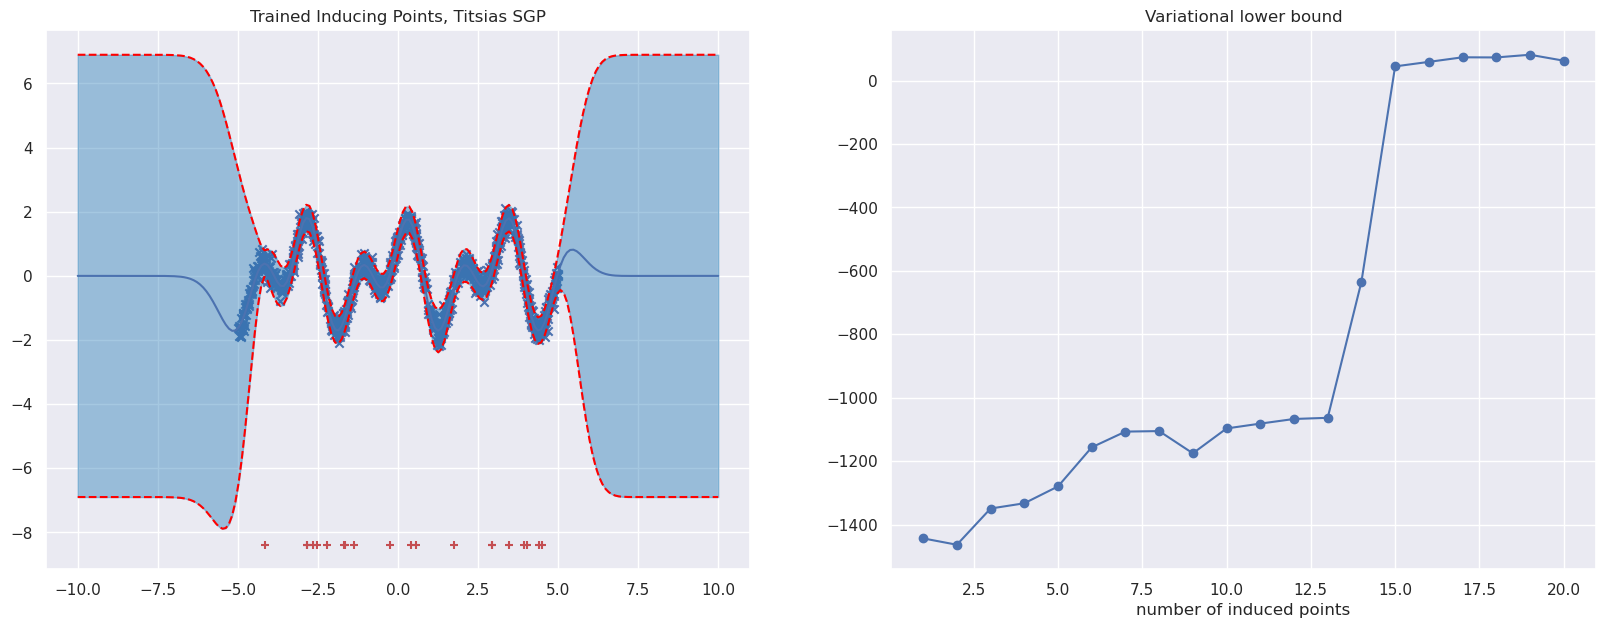

In [24]:
plot_regression(greedy , X_Star , PM , std , ML )

In [28]:
error_method3_lossy = np.sum((Y[::5] - PM)**2)


NameError: name 'PM' is not defined

ERRORS

In [29]:
error_method1*1000, error_method2, error_method3_lossy

NameError: name 'error_method3_lossy' is not defined

In [38]:
import gpjax as gpx
import optax as ox


2022-11-08 10:31:38.780489: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 10:31:39.354465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:/opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:
2022-11-08 10:31:39.354590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/l

In [39]:
kernel = gpx.RBF()
prior = gpx.Prior(kernel=kernel)


In [40]:
D = gpx.Dataset(X=x, y=y)
likelihood = gpx.Gaussian(num_datapoints=D.n)


In [41]:
posterior = prior * likelihood


In [42]:
parameter_state = gpx.initialise(
    posterior, key, kernel={'lengthscale': jnp.array([0.5])})
print(type(parameter_state))


<class 'gpjax.parameters.ParameterState'>


In [43]:
params, trainable, constrainer, unconstrainer = parameter_state.unpack()

In [44]:
params = gpx.transform(params, unconstrainer)


In [45]:
mll = jit(posterior.marginal_log_likelihood(D, constrainer, negative=True))
mll(params)

DeviceArray(991.63792025, dtype=float64)

In [46]:
opt = ox.adam(learning_rate=0.01)
inference_state = gpx.fit(
    mll,
    params,
    trainable,
    opt,
    n_iters=500,
)


  0%|          | 0/500 [00:00<?, ?it/s]

In [47]:
final_params, training_history = inference_state.unpack()


In [48]:
final_params = gpx.transform(final_params, constrainer)


In [49]:
latent_dist = posterior(D, final_params)(xtest)
predictive_dist = likelihood(latent_dist, final_params)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()


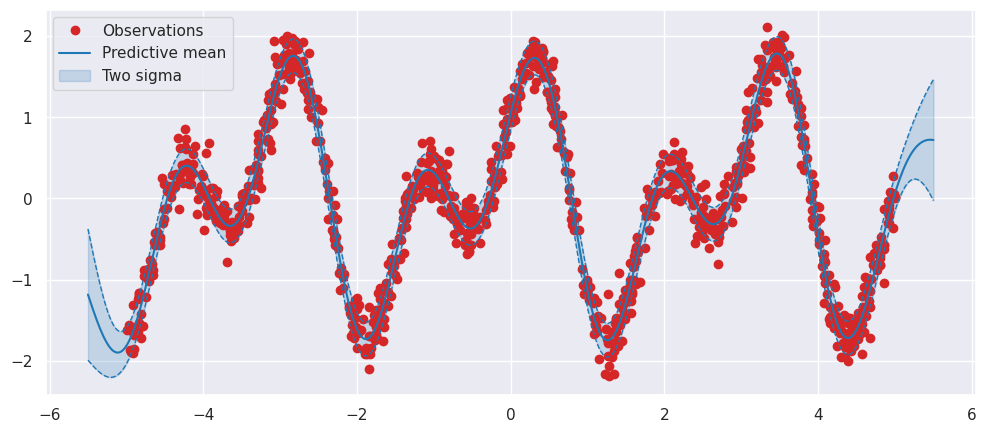

In [50]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label='Two sigma',
)
ax.plot(xtest, predictive_mean - predictive_std,
        color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, predictive_mean + predictive_std,
        color="tab:blue", linestyle="--", linewidth=1)
ax.legend()


In [51]:
latent_dist = posterior(D, final_params)(x)
predictive_dist = likelihood(latent_dist, final_params)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()


In [66]:
np.sum((y-predictive_mean.reshape(-1,1))**2)

DeviceArray(40.07794144, dtype=float64)

In [67]:
likelihood = gpx.Gaussian(num_datapoints=n)
prior = gpx.Prior(kernel=gpx.RBF())
p = prior * likelihood
q = gpx.VariationalGaussian(prior=prior, inducing_inputs=z)
svgp = gpx.StochasticVI(posterior=p, variational_family=q)


params, trainables, constrainers, unconstrainers = gpx.initialise(
    svgp, key).unpack()
params = gpx.transform(params, unconstrainers)

loss_fn = jit(svgp.elbo(D, constrainers, negative=True))


In [68]:
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit_batches(
    objective=loss_fn,
    params=params,
    trainables=trainables,
    train_data=D,
    optax_optim=optimiser,
    n_iters=4000,
    key=jr.PRNGKey(42),
    batch_size=128
)
learned_params, training_history = inference_state.unpack()
learned_params = gpx.transform(learned_params, constrainers)


  0%|          | 0/4000 [00:00<?, ?it/s]

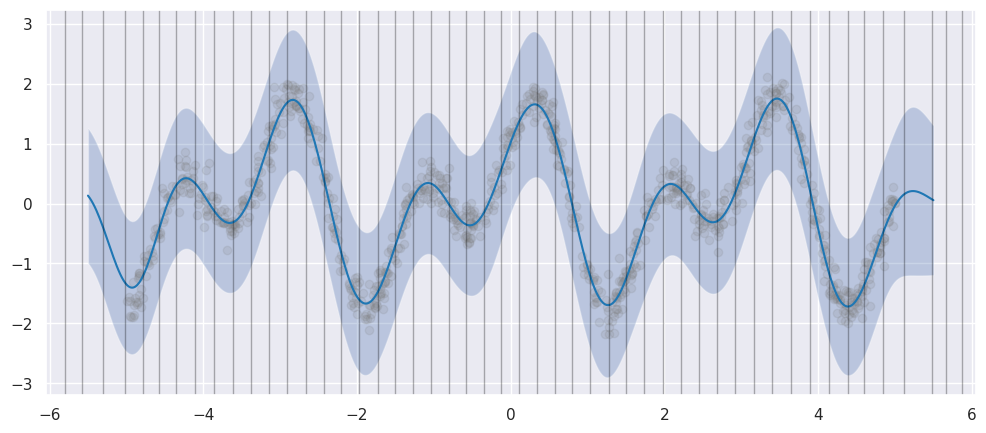

In [69]:
latent_dist = q(learned_params)(xtest)
predictive_dist = likelihood(latent_dist, learned_params)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(xtest, meanf, label="Posterior mean", color="tab:blue")
ax.fill_between(xtest.flatten(), meanf - sigma, meanf + sigma, alpha=0.3)
[
    ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1)
    for z_i in learned_params["variational_family"]["inducing_inputs"]
]
plt.show()


In [71]:
latent_dist = q(learned_params)(x)
predictive_dist = likelihood(latent_dist, learned_params)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

np.sum((y-meanf.reshape(-1,1))**2)

DeviceArray(41.87024134, dtype=float64)